##**DCGAN: Deep Convolutional Generative Adversarial Networks**

## Results here

https://docs.google.com/document/d/1jpzyfFsURqjRD_p7VnIxBXSi92qft3SZPE0RIHaNqxs/edit?usp=sharing

###**Task**: Train and test the GAN with different distributions for Z~p(z)

| **Student id**       | **$Z_{Train}$**     | **$Z_{Test}$**    |
| :-----------:        | :-----------: | :---------: |
| 1                    | normal        |  uniform    |
| 2                    | normal        |  weibull    |
| 3                    | uniform       |  normal     |
| 4                    | uniform       |  weibull    |
| 5                    | weibull       |  normal     |
| 6                    | weibull       |  uniform    |
| 7                    | normal        |  uniform     |
| 8                    | normal       |  weibull    |
| 9                    | uniform       |  normal     |
| 10                    | uniform       |  weibull    |
| 11                    | weibull       |  normal     |





###**Display random distributions**
Three types of noise distributions: Normal, uniform and weibull

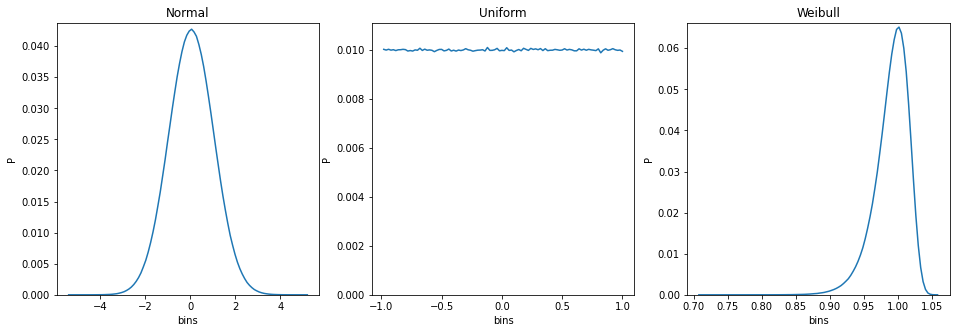

In [ ]:
# Distributions
import numpy as np
import matplotlib.pyplot as plt

n = 10000000

d_normal , b_normal  = np.histogram(np.random.normal(0, 1, n), bins=100)
d_uniform, b_uniform = np.histogram(np.random.uniform(-1, 1, n), bins=100)
d_weibull, b_weibull = np.histogram(np.random.weibull(50, n), bins=100)

plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.plot(b_normal[1:], d_normal/n)
plt.ylim([0, max(d_normal/n) + 1e-3])
plt.title('Normal')
plt.xlabel('bins'); plt.ylabel('P');

plt.subplot(1,3,2); plt.plot(b_uniform[1:], d_uniform/n)
plt.ylim([0, max(d_uniform/n) + 1e-3])
plt.title('Uniform')
plt.xlabel('bins'); plt.ylabel('P');

plt.subplot(1,3,3); plt.plot(b_weibull[1:], d_weibull/n)
plt.ylim([0, max(d_weibull/n) + 1e-3])
plt.title('Weibull')
plt.xlabel('bins'); plt.ylabel('P');

plt.show()


###**Download dataset**

In [ ]:
!pip install googleDriveFileDownloader
from googleDriveFileDownloader import googleDriveFileDownloader
a = googleDriveFileDownloader()
a.downloadFile("https://drive.google.com/uc?id=1PjYG1ElJTgLhj9tS8MHW93k8qT4wRj6E&export=download")

from zipfile import ZipFile
with ZipFile('dataset.zip', 'r') as myzip:
    myzip.extractall()
dataset_dir = "/content/dataset"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Download is starting
FILENAME ::: dataset.zip


###**Create output folder**

In [ ]:
# mount your Google Drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/Face_generation/'
if not os.path.exists(output_dir): os.makedirs(output_dir)

Mounted at /content/drive


###**Packages**

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, Dropout
from keras.layers.core import Activation
from keras.optimizers import adam_v2
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###**Parameters**

In [ ]:
# Parameters
OPTIMIZER = adam_v2.Adam(lr=1e-4)
INPUT_SHAPE = 128
LOSS = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
BATCH_SIZE = 16
EPOCHS = 260

#################### CODE HERE ################################
#Distributions: 'normal', 'weibull', 'uniform'
DISTRIBUTION_train = 'normal'
DISTRIBUTION_test  = 'weibull'
###############################################################

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


###**Load Dataset**

Creating training set...Done!
Training set:  (3754, 128, 128, 3)


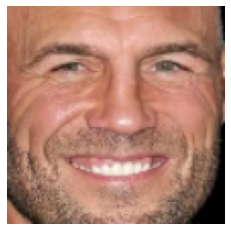

In [ ]:
def load_data():
  print('Creating training set...',end="",flush=True)
  filelist = os.listdir(dataset_dir)

  n_imgs = len(filelist)
  x_train = np.zeros((n_imgs,128,128,3))

  for i, fname in enumerate(filelist):
    if fname != '.DS_Store':
      imagen = imread(os.path.join(dataset_dir,fname))
      x_train[i,:] = (imagen - 127.5)/127.5
  print('Done!')
  print('Training set: ', x_train.shape)

  return x_train

# Visualizing images from the training set
def plot_image(img_i, x_train):
	image = (x_train[img_i,:]*127.5) + 127.5
	image = np.ndarray.astype(image, np.uint8)
	plt.imshow(image.reshape(128,128,3))
	plt.axis('off')
	plt.show()

# create Training set
x_train = load_data()
plot_image(np.random.randint(0, x_train.shape[0]), x_train)

##**Networks**

###Generator

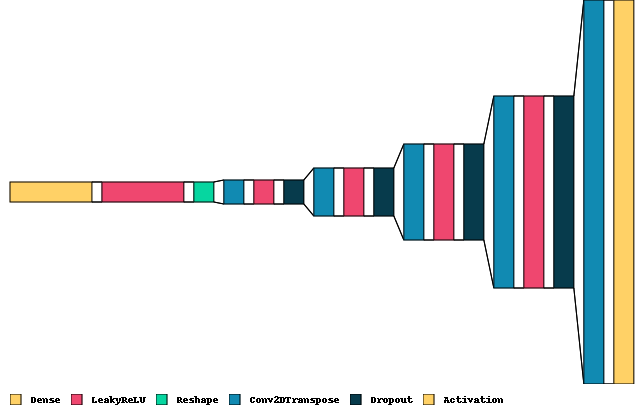

In [ ]:
def create_generator():
    model = Sequential()
    model.add(Dense(1024*4*4, input_shape=(INPUT_SHAPE,)))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    model.add(Reshape((4,4,1024)))
    #4x4x1024

    model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    model.add(Dropout(0.1))
    #8x8x512

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    model.add(Dropout(0.1))
    #16x16x256

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    model.add(Dropout(0.1))
    #32x32x256

    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    model.add(Dropout(0.1))
    #64x64x64

    model.add(Conv2DTranspose(3, (5,5), strides=(2,2), padding='same'))
    model.add(Activation('tanh'))
    #128x128x3

    model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

generator = create_generator()
#generator.summary()
visualkeras.layered_view(generator, type_ignore=[], legend=True, scale_z=0.005, scale_xy=3, draw_volume=False)

###Discriminator

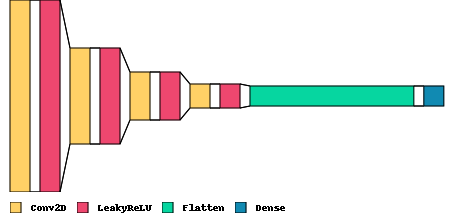

In [ ]:
def create_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=(128,128,3)))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    model.add(Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    model.add(Conv2D(512, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

discriminador = create_discriminator()
#discriminador.summary()
visualkeras.layered_view(discriminador, type_ignore=[], legend=True, scale_z=0.005, scale_xy=3, draw_volume=False)

###GAN

In [ ]:
# GAN
def create_GAN(generator, discriminador):
    model = Sequential()
    model.add(generator)
    discriminador.trainable = False
    model.add(discriminador)
    model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

gan = create_GAN(generator, discriminador)
gan.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       13915907  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2789313   
                                                                 
Total params: 16,705,220
Trainable params: 13,915,907
Non-trainable params: 2,789,313
_________________________________________________________________


###**Training**

In [ ]:
#Input random vector
def rand_vector(distribution, size):

    if distribution == "normal":
        return np.random.normal(0.0, 1.0, size)
    
    elif distribution == "uniform":
        return np.random.uniform(-1.0, 1.0, size)

    elif distribution == "weibull":
        q = np.random.weibull(50, size)
        return (q - np.mean(q)) / np.std(q)
    
    else:
        print('specify distribution')
        import sys; sys.exit()

# Generate and visualize images
def plot_generated_images(id, generator, input_dist, samples=9, dim=(3,3), figsize=(5,5)):
    noise = rand_vector(input_dist, (samples, INPUT_SHAPE))
    generated_images = generator.predict(noise)
    generated_images.reshape(samples,128,128,3)
    generated_images = generated_images*127.5 + 127.5
    plt.figure(figsize=figsize)
    for i in range(samples):
        plt.subplot(dim[0],dim[1], i+1)
        plt.imshow(generated_images[i].astype('uint8'), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_dir + 'GAN_image_%s.png' %(id))
    plt.show()
#    plt.close()


#### Training steps
In each batch:
1. Train discriminator
  - Predict fake images from generator
  - Reference is 1 for real images, 0 for fake images
  - Train discriminator (With generator frozen)
2. Train generator
  - Freeze discriminator weights
  - "gan" model produces the fake images from random noise, and the discriminator outcome. Train "gan" model with frozen discriminator
  - Reference is 1 for fake images (Fool the discriminator)

Epoch: 1, [Time: 37.79 seg], g_loss: 3.8, d_loss: 0.2


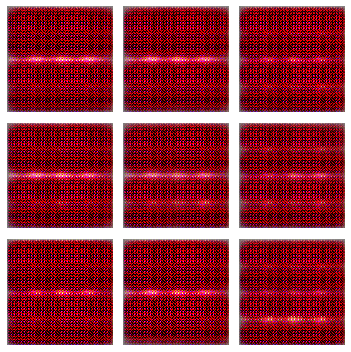

Epoch: 2, [Time: 73.20 seg], g_loss: 4.5, d_loss: 0.1
Epoch: 3, [Time: 104.95 seg], g_loss: 4.2, d_loss: 0.1
Epoch: 4, [Time: 136.09 seg], g_loss: 3.6, d_loss: 0.2
Epoch: 5, [Time: 168.57 seg], g_loss: 3.4, d_loss: 0.2
Epoch: 6, [Time: 200.08 seg], g_loss: 1.9, d_loss: 0.3
Epoch: 7, [Time: 230.65 seg], g_loss: 4.8, d_loss: 0.1
Epoch: 8, [Time: 261.00 seg], g_loss: 3.4, d_loss: 0.4
Epoch: 9, [Time: 290.74 seg], g_loss: 3.3, d_loss: 0.2
Epoch: 10, [Time: 320.19 seg], g_loss: 1.5, d_loss: 0.3


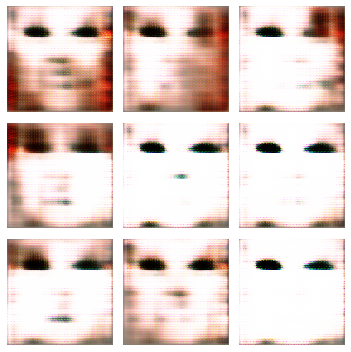

Epoch: 11, [Time: 358.07 seg], g_loss: 2.3, d_loss: 0.5
Epoch: 12, [Time: 387.45 seg], g_loss: 2.7, d_loss: 0.3
Epoch: 13, [Time: 416.81 seg], g_loss: 2.2, d_loss: 0.3
Epoch: 14, [Time: 445.52 seg], g_loss: 2.0, d_loss: 0.4
Epoch: 15, [Time: 474.35 seg], g_loss: 4.3, d_loss: 0.3
Epoch: 16, [Time: 503.48 seg], g_loss: 1.9, d_loss: 0.3
Epoch: 17, [Time: 532.42 seg], g_loss: 3.9, d_loss: 0.3
Epoch: 18, [Time: 560.77 seg], g_loss: 1.6, d_loss: 0.5
Epoch: 19, [Time: 588.90 seg], g_loss: 2.3, d_loss: 0.4
Epoch: 20, [Time: 616.91 seg], g_loss: 2.2, d_loss: 0.4


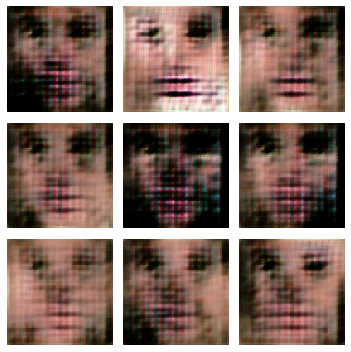

Epoch: 21, [Time: 652.42 seg], g_loss: 2.3, d_loss: 0.6
Epoch: 22, [Time: 679.34 seg], g_loss: 1.8, d_loss: 0.3
Epoch: 23, [Time: 707.04 seg], g_loss: 2.1, d_loss: 0.7
Epoch: 24, [Time: 734.68 seg], g_loss: 2.5, d_loss: 0.3
Epoch: 25, [Time: 762.63 seg], g_loss: 1.8, d_loss: 0.3
Epoch: 26, [Time: 790.22 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 27, [Time: 818.33 seg], g_loss: 3.0, d_loss: 0.4
Epoch: 28, [Time: 848.86 seg], g_loss: 1.3, d_loss: 0.7
Epoch: 29, [Time: 880.81 seg], g_loss: 2.3, d_loss: 0.4
Epoch: 30, [Time: 913.08 seg], g_loss: 2.8, d_loss: 0.4


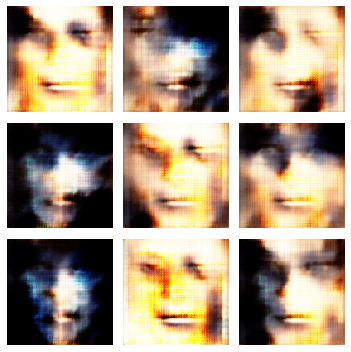

Epoch: 31, [Time: 951.60 seg], g_loss: 2.2, d_loss: 0.3
Epoch: 32, [Time: 981.30 seg], g_loss: 2.6, d_loss: 0.3
Epoch: 33, [Time: 1010.14 seg], g_loss: 3.5, d_loss: 0.4
Epoch: 34, [Time: 1039.35 seg], g_loss: 1.4, d_loss: 0.9
Epoch: 35, [Time: 1068.45 seg], g_loss: 2.7, d_loss: 0.4
Epoch: 36, [Time: 1096.93 seg], g_loss: 2.7, d_loss: 0.5
Epoch: 37, [Time: 1124.45 seg], g_loss: 2.7, d_loss: 0.3
Epoch: 38, [Time: 1152.17 seg], g_loss: 3.0, d_loss: 0.5
Epoch: 39, [Time: 1180.59 seg], g_loss: 2.0, d_loss: 0.4
Epoch: 40, [Time: 1208.45 seg], g_loss: 2.8, d_loss: 0.6


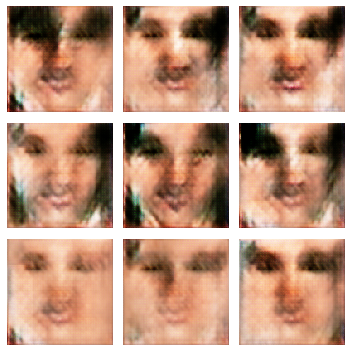

Epoch: 41, [Time: 1244.14 seg], g_loss: 2.3, d_loss: 0.6
Epoch: 42, [Time: 1272.58 seg], g_loss: 1.9, d_loss: 0.6
Epoch: 43, [Time: 1300.75 seg], g_loss: 3.4, d_loss: 0.2
Epoch: 44, [Time: 1329.76 seg], g_loss: 2.4, d_loss: 0.4
Epoch: 45, [Time: 1357.68 seg], g_loss: 2.5, d_loss: 0.3
Epoch: 46, [Time: 1385.01 seg], g_loss: 2.7, d_loss: 0.5
Epoch: 47, [Time: 1413.20 seg], g_loss: 2.4, d_loss: 0.4
Epoch: 48, [Time: 1441.18 seg], g_loss: 2.2, d_loss: 0.3
Epoch: 49, [Time: 1468.47 seg], g_loss: 1.7, d_loss: 0.4
Epoch: 50, [Time: 1496.68 seg], g_loss: 2.3, d_loss: 0.6


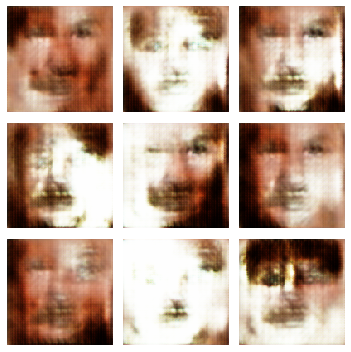

Epoch: 51, [Time: 1531.94 seg], g_loss: 2.5, d_loss: 0.5
Epoch: 52, [Time: 1559.46 seg], g_loss: 3.2, d_loss: 0.4
Epoch: 53, [Time: 1586.92 seg], g_loss: 2.3, d_loss: 0.3
Epoch: 54, [Time: 1614.06 seg], g_loss: 1.8, d_loss: 0.3
Epoch: 55, [Time: 1641.70 seg], g_loss: 2.4, d_loss: 0.4
Epoch: 56, [Time: 1669.07 seg], g_loss: 2.8, d_loss: 0.4
Epoch: 57, [Time: 1696.13 seg], g_loss: 2.2, d_loss: 0.4
Epoch: 58, [Time: 1723.38 seg], g_loss: 2.3, d_loss: 0.2
Epoch: 59, [Time: 1751.11 seg], g_loss: 3.6, d_loss: 0.3
Epoch: 60, [Time: 1777.83 seg], g_loss: 3.2, d_loss: 0.6


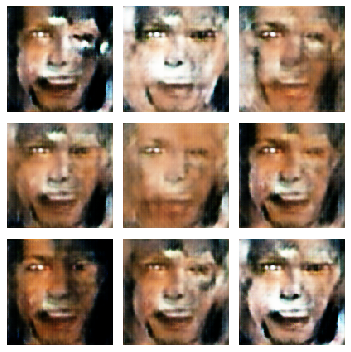

Epoch: 61, [Time: 1812.06 seg], g_loss: 2.2, d_loss: 0.7
Epoch: 62, [Time: 1839.26 seg], g_loss: 3.1, d_loss: 0.4
Epoch: 63, [Time: 1866.32 seg], g_loss: 3.0, d_loss: 0.2
Epoch: 64, [Time: 1893.66 seg], g_loss: 2.3, d_loss: 0.4
Epoch: 65, [Time: 1921.10 seg], g_loss: 2.5, d_loss: 0.6
Epoch: 66, [Time: 1949.43 seg], g_loss: 3.0, d_loss: 0.5
Epoch: 67, [Time: 1977.87 seg], g_loss: 3.4, d_loss: 0.3
Epoch: 68, [Time: 2006.47 seg], g_loss: 2.6, d_loss: 0.3
Epoch: 69, [Time: 2034.95 seg], g_loss: 2.9, d_loss: 0.4
Epoch: 70, [Time: 2063.42 seg], g_loss: 2.6, d_loss: 0.6


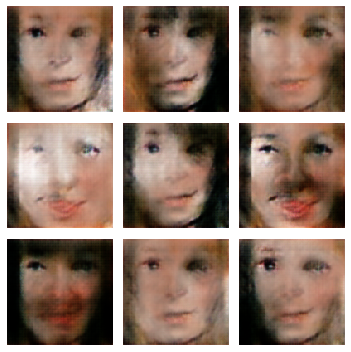

Epoch: 71, [Time: 2101.76 seg], g_loss: 2.1, d_loss: 0.4
Epoch: 72, [Time: 2132.54 seg], g_loss: 2.8, d_loss: 0.3
Epoch: 73, [Time: 2161.98 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 74, [Time: 2190.55 seg], g_loss: 2.2, d_loss: 0.4
Epoch: 75, [Time: 2218.88 seg], g_loss: 2.7, d_loss: 0.6
Epoch: 76, [Time: 2247.07 seg], g_loss: 2.0, d_loss: 0.3
Epoch: 77, [Time: 2275.13 seg], g_loss: 3.2, d_loss: 0.7
Epoch: 78, [Time: 2302.88 seg], g_loss: 2.3, d_loss: 0.4
Epoch: 79, [Time: 2330.42 seg], g_loss: 2.7, d_loss: 0.7
Epoch: 80, [Time: 2358.02 seg], g_loss: 2.2, d_loss: 0.4


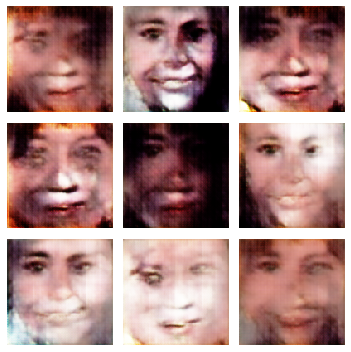

Epoch: 81, [Time: 2394.27 seg], g_loss: 3.3, d_loss: 0.6
Epoch: 82, [Time: 2422.88 seg], g_loss: 2.4, d_loss: 0.4
Epoch: 83, [Time: 2450.80 seg], g_loss: 3.2, d_loss: 0.4
Epoch: 84, [Time: 2478.43 seg], g_loss: 2.8, d_loss: 0.3
Epoch: 85, [Time: 2506.75 seg], g_loss: 2.9, d_loss: 0.2
Epoch: 86, [Time: 2534.89 seg], g_loss: 3.3, d_loss: 0.2
Epoch: 87, [Time: 2563.25 seg], g_loss: 3.0, d_loss: 0.4
Epoch: 88, [Time: 2591.40 seg], g_loss: 2.6, d_loss: 0.2
Epoch: 89, [Time: 2618.44 seg], g_loss: 3.8, d_loss: 0.3
Epoch: 90, [Time: 2646.04 seg], g_loss: 2.1, d_loss: 0.3


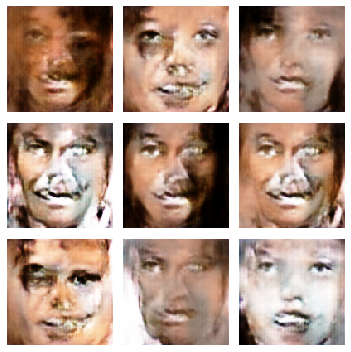

Epoch: 91, [Time: 2682.88 seg], g_loss: 2.9, d_loss: 0.3
Epoch: 92, [Time: 2713.56 seg], g_loss: 2.2, d_loss: 0.3
Epoch: 93, [Time: 2743.49 seg], g_loss: 2.3, d_loss: 0.5
Epoch: 94, [Time: 2772.96 seg], g_loss: 2.4, d_loss: 0.4
Epoch: 95, [Time: 2802.80 seg], g_loss: 3.2, d_loss: 0.3
Epoch: 96, [Time: 2831.99 seg], g_loss: 2.6, d_loss: 0.3
Epoch: 97, [Time: 2861.53 seg], g_loss: 2.3, d_loss: 0.4
Epoch: 98, [Time: 2890.66 seg], g_loss: 2.3, d_loss: 0.4
Epoch: 99, [Time: 2919.20 seg], g_loss: 4.4, d_loss: 0.4
Epoch: 100, [Time: 2947.77 seg], g_loss: 2.8, d_loss: 0.3


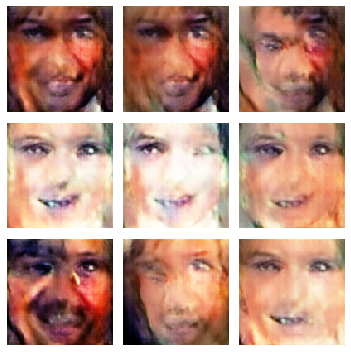

Epoch: 101, [Time: 2985.29 seg], g_loss: 2.7, d_loss: 0.2
Epoch: 102, [Time: 3014.35 seg], g_loss: 2.7, d_loss: 0.2
Epoch: 103, [Time: 3043.12 seg], g_loss: 3.0, d_loss: 0.4
Epoch: 104, [Time: 3071.49 seg], g_loss: 2.3, d_loss: 0.5
Epoch: 105, [Time: 3100.11 seg], g_loss: 3.8, d_loss: 0.2
Epoch: 106, [Time: 3129.10 seg], g_loss: 3.2, d_loss: 0.5
Epoch: 107, [Time: 3157.67 seg], g_loss: 2.5, d_loss: 0.2
Epoch: 108, [Time: 3184.11 seg], g_loss: 3.3, d_loss: 0.2
Epoch: 109, [Time: 3210.91 seg], g_loss: 3.5, d_loss: 0.4
Epoch: 110, [Time: 3237.88 seg], g_loss: 2.9, d_loss: 0.3


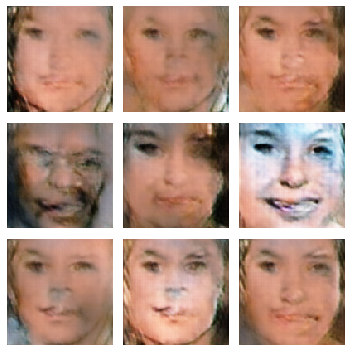

Epoch: 111, [Time: 3272.89 seg], g_loss: 2.9, d_loss: 0.5
Epoch: 112, [Time: 3299.74 seg], g_loss: 3.2, d_loss: 0.1
Epoch: 113, [Time: 3326.80 seg], g_loss: 3.2, d_loss: 0.3
Epoch: 114, [Time: 3353.46 seg], g_loss: 3.0, d_loss: 0.6
Epoch: 115, [Time: 3380.12 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 116, [Time: 3406.77 seg], g_loss: 3.8, d_loss: 0.3
Epoch: 117, [Time: 3433.69 seg], g_loss: 3.5, d_loss: 0.5
Epoch: 118, [Time: 3460.49 seg], g_loss: 2.1, d_loss: 0.3
Epoch: 119, [Time: 3487.26 seg], g_loss: 3.4, d_loss: 0.5
Epoch: 120, [Time: 3514.00 seg], g_loss: 2.4, d_loss: 0.3


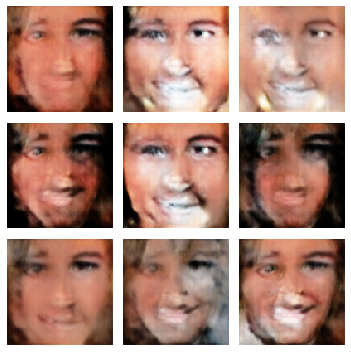

Epoch: 121, [Time: 3549.00 seg], g_loss: 2.3, d_loss: 0.5
Epoch: 122, [Time: 3575.89 seg], g_loss: 3.2, d_loss: 0.4
Epoch: 123, [Time: 3603.10 seg], g_loss: 3.9, d_loss: 0.3
Epoch: 124, [Time: 3630.26 seg], g_loss: 2.4, d_loss: 0.3
Epoch: 125, [Time: 3657.97 seg], g_loss: 3.1, d_loss: 0.4
Epoch: 126, [Time: 3686.60 seg], g_loss: 3.2, d_loss: 0.3
Epoch: 127, [Time: 3715.88 seg], g_loss: 2.7, d_loss: 0.3
Epoch: 128, [Time: 3745.43 seg], g_loss: 3.3, d_loss: 0.2
Epoch: 129, [Time: 3775.14 seg], g_loss: 3.0, d_loss: 0.3
Epoch: 130, [Time: 3805.12 seg], g_loss: 3.8, d_loss: 0.2


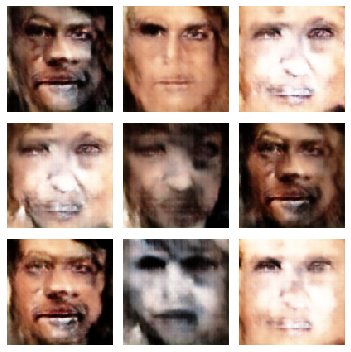

Epoch: 131, [Time: 3843.99 seg], g_loss: 2.5, d_loss: 0.3
Epoch: 132, [Time: 3872.86 seg], g_loss: 2.4, d_loss: 0.2
Epoch: 133, [Time: 3901.04 seg], g_loss: 3.3, d_loss: 0.4
Epoch: 134, [Time: 3929.31 seg], g_loss: 2.7, d_loss: 0.4
Epoch: 135, [Time: 3956.89 seg], g_loss: 3.9, d_loss: 0.1
Epoch: 136, [Time: 3985.17 seg], g_loss: 2.6, d_loss: 0.4
Epoch: 137, [Time: 4012.61 seg], g_loss: 3.0, d_loss: 0.3
Epoch: 138, [Time: 4039.97 seg], g_loss: 3.1, d_loss: 0.2
Epoch: 139, [Time: 4070.41 seg], g_loss: 2.5, d_loss: 0.2
Epoch: 140, [Time: 4100.90 seg], g_loss: 3.6, d_loss: 0.3


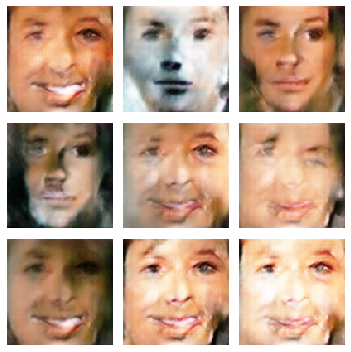

Epoch: 141, [Time: 4136.74 seg], g_loss: 3.6, d_loss: 0.3
Epoch: 142, [Time: 4165.17 seg], g_loss: 4.5, d_loss: 0.3
Epoch: 143, [Time: 4193.68 seg], g_loss: 2.5, d_loss: 0.2
Epoch: 144, [Time: 4221.73 seg], g_loss: 2.4, d_loss: 0.5
Epoch: 145, [Time: 4249.12 seg], g_loss: 3.5, d_loss: 0.3
Epoch: 146, [Time: 4276.02 seg], g_loss: 3.2, d_loss: 0.2
Epoch: 147, [Time: 4302.90 seg], g_loss: 4.1, d_loss: 0.3
Epoch: 148, [Time: 4330.05 seg], g_loss: 3.4, d_loss: 0.3
Epoch: 149, [Time: 4358.10 seg], g_loss: 2.8, d_loss: 0.2
Epoch: 150, [Time: 4386.02 seg], g_loss: 2.9, d_loss: 0.4


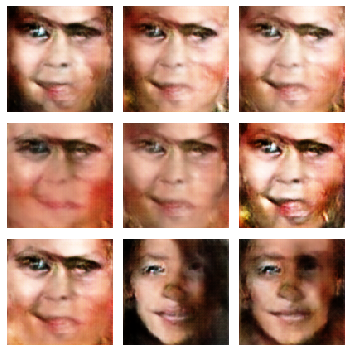

Epoch: 151, [Time: 4420.82 seg], g_loss: 3.0, d_loss: 0.3
Epoch: 152, [Time: 4448.68 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 153, [Time: 4476.71 seg], g_loss: 3.2, d_loss: 0.5
Epoch: 154, [Time: 4504.32 seg], g_loss: 3.4, d_loss: 0.3
Epoch: 155, [Time: 4532.46 seg], g_loss: 3.2, d_loss: 0.2
Epoch: 156, [Time: 4560.24 seg], g_loss: 3.1, d_loss: 0.2
Epoch: 157, [Time: 4587.92 seg], g_loss: 2.8, d_loss: 0.2
Epoch: 158, [Time: 4615.57 seg], g_loss: 3.3, d_loss: 0.3
Epoch: 159, [Time: 4643.22 seg], g_loss: 3.3, d_loss: 0.4
Epoch: 160, [Time: 4670.48 seg], g_loss: 2.5, d_loss: 0.2


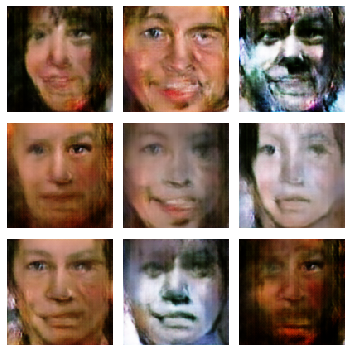

Epoch: 161, [Time: 4707.80 seg], g_loss: 3.3, d_loss: 0.5
Epoch: 162, [Time: 4734.98 seg], g_loss: 3.1, d_loss: 0.2
Epoch: 163, [Time: 4762.80 seg], g_loss: 2.9, d_loss: 0.3
Epoch: 164, [Time: 4790.69 seg], g_loss: 3.0, d_loss: 0.2
Epoch: 165, [Time: 4819.48 seg], g_loss: 3.4, d_loss: 0.3
Epoch: 166, [Time: 4848.31 seg], g_loss: 3.7, d_loss: 0.2
Epoch: 167, [Time: 4876.90 seg], g_loss: 3.6, d_loss: 0.3
Epoch: 168, [Time: 4905.76 seg], g_loss: 3.2, d_loss: 0.4
Epoch: 169, [Time: 4934.45 seg], g_loss: 4.4, d_loss: 0.3
Epoch: 170, [Time: 4962.88 seg], g_loss: 2.4, d_loss: 0.3


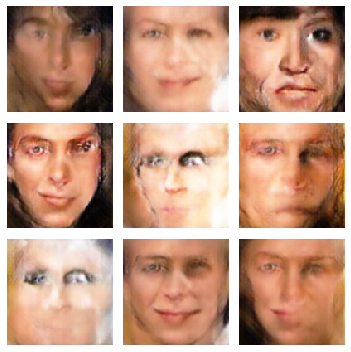

Epoch: 171, [Time: 4998.63 seg], g_loss: 3.8, d_loss: 0.2
Epoch: 172, [Time: 5027.13 seg], g_loss: 2.9, d_loss: 0.2
Epoch: 173, [Time: 5055.33 seg], g_loss: 2.7, d_loss: 0.4
Epoch: 174, [Time: 5084.07 seg], g_loss: 3.2, d_loss: 0.3
Epoch: 175, [Time: 5112.48 seg], g_loss: 3.8, d_loss: 0.2
Epoch: 176, [Time: 5141.02 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 177, [Time: 5169.35 seg], g_loss: 3.9, d_loss: 0.1
Epoch: 178, [Time: 5197.55 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 179, [Time: 5225.27 seg], g_loss: 3.7, d_loss: 0.3
Epoch: 180, [Time: 5253.43 seg], g_loss: 2.5, d_loss: 0.2


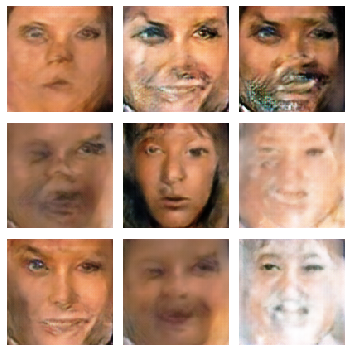

Epoch: 181, [Time: 5288.95 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 182, [Time: 5316.96 seg], g_loss: 3.6, d_loss: 0.1
Epoch: 183, [Time: 5345.26 seg], g_loss: 4.4, d_loss: 0.6
Epoch: 184, [Time: 5373.94 seg], g_loss: 3.5, d_loss: 0.4
Epoch: 185, [Time: 5402.96 seg], g_loss: 3.2, d_loss: 0.2
Epoch: 186, [Time: 5431.78 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 187, [Time: 5459.42 seg], g_loss: 3.2, d_loss: 0.2
Epoch: 188, [Time: 5487.43 seg], g_loss: 4.1, d_loss: 0.3
Epoch: 189, [Time: 5515.76 seg], g_loss: 3.7, d_loss: 0.4
Epoch: 190, [Time: 5544.48 seg], g_loss: 3.2, d_loss: 0.3


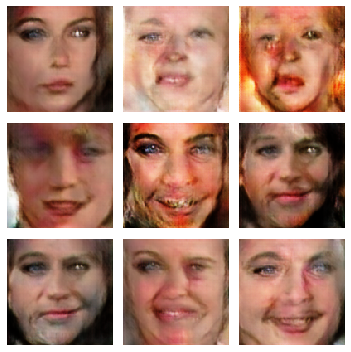

Epoch: 191, [Time: 5579.57 seg], g_loss: 3.1, d_loss: 0.4
Epoch: 192, [Time: 5607.36 seg], g_loss: 4.5, d_loss: 0.5
Epoch: 193, [Time: 5635.20 seg], g_loss: 3.6, d_loss: 0.2
Epoch: 194, [Time: 5662.67 seg], g_loss: 4.1, d_loss: 0.5
Epoch: 195, [Time: 5689.87 seg], g_loss: 3.2, d_loss: 0.2
Epoch: 196, [Time: 5717.40 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 197, [Time: 5746.33 seg], g_loss: 4.3, d_loss: 0.2
Epoch: 198, [Time: 5775.41 seg], g_loss: 3.2, d_loss: 0.3
Epoch: 199, [Time: 5804.81 seg], g_loss: 2.7, d_loss: 0.2
Epoch: 200, [Time: 5833.35 seg], g_loss: 3.2, d_loss: 0.3


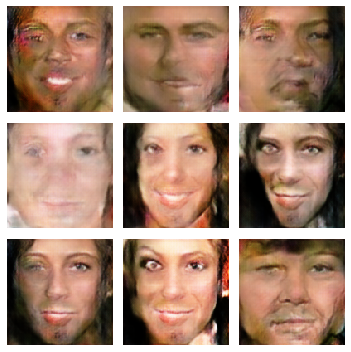

Epoch: 201, [Time: 5870.22 seg], g_loss: 3.6, d_loss: 0.3
Epoch: 202, [Time: 5898.38 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 203, [Time: 5926.14 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 204, [Time: 5953.79 seg], g_loss: 3.7, d_loss: 0.3
Epoch: 205, [Time: 5981.26 seg], g_loss: 3.6, d_loss: 0.2
Epoch: 206, [Time: 6008.87 seg], g_loss: 2.7, d_loss: 0.2
Epoch: 207, [Time: 6036.64 seg], g_loss: 3.3, d_loss: 0.4
Epoch: 208, [Time: 6064.20 seg], g_loss: 4.3, d_loss: 0.7
Epoch: 209, [Time: 6092.63 seg], g_loss: 2.8, d_loss: 0.3
Epoch: 210, [Time: 6120.67 seg], g_loss: 3.4, d_loss: 0.5


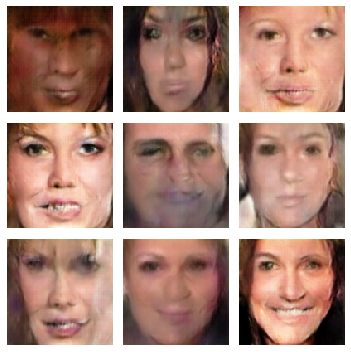

Epoch: 211, [Time: 6155.86 seg], g_loss: 3.8, d_loss: 0.2
Epoch: 212, [Time: 6183.88 seg], g_loss: 2.9, d_loss: 0.2
Epoch: 213, [Time: 6211.61 seg], g_loss: 2.4, d_loss: 0.4
Epoch: 214, [Time: 6238.97 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 215, [Time: 6266.56 seg], g_loss: 3.2, d_loss: 0.4
Epoch: 216, [Time: 6294.48 seg], g_loss: 3.6, d_loss: 0.6
Epoch: 217, [Time: 6322.63 seg], g_loss: 3.0, d_loss: 0.2
Epoch: 218, [Time: 6350.90 seg], g_loss: 2.4, d_loss: 0.2
Epoch: 219, [Time: 6379.39 seg], g_loss: 3.9, d_loss: 0.3
Epoch: 220, [Time: 6407.40 seg], g_loss: 3.7, d_loss: 0.4


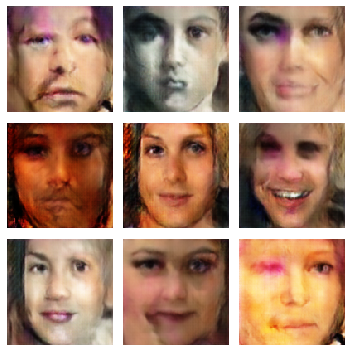

Epoch: 221, [Time: 6443.35 seg], g_loss: 2.9, d_loss: 0.2
Epoch: 222, [Time: 6473.30 seg], g_loss: 4.4, d_loss: 0.2
Epoch: 223, [Time: 6501.25 seg], g_loss: 2.9, d_loss: 0.4
Epoch: 224, [Time: 6529.33 seg], g_loss: 3.5, d_loss: 0.5
Epoch: 225, [Time: 6557.48 seg], g_loss: 3.1, d_loss: 0.4
Epoch: 226, [Time: 6585.27 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 227, [Time: 6613.28 seg], g_loss: 3.0, d_loss: 0.3
Epoch: 228, [Time: 6641.84 seg], g_loss: 3.6, d_loss: 0.2
Epoch: 229, [Time: 6672.17 seg], g_loss: 3.4, d_loss: 0.3
Epoch: 230, [Time: 6702.34 seg], g_loss: 3.1, d_loss: 0.4


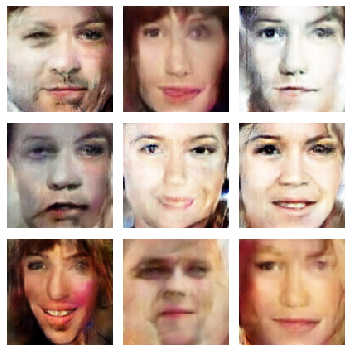

Epoch: 231, [Time: 6740.09 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 232, [Time: 6769.28 seg], g_loss: 3.6, d_loss: 0.3
Epoch: 233, [Time: 6798.23 seg], g_loss: 3.3, d_loss: 0.4
Epoch: 234, [Time: 6827.44 seg], g_loss: 2.1, d_loss: 0.3
Epoch: 235, [Time: 6856.37 seg], g_loss: 2.9, d_loss: 0.3
Epoch: 236, [Time: 6885.42 seg], g_loss: 2.7, d_loss: 0.3
Epoch: 237, [Time: 6913.94 seg], g_loss: 2.9, d_loss: 0.4
Epoch: 238, [Time: 6941.86 seg], g_loss: 2.5, d_loss: 0.2
Epoch: 239, [Time: 6969.43 seg], g_loss: 4.0, d_loss: 0.4
Epoch: 240, [Time: 6997.42 seg], g_loss: 3.5, d_loss: 0.5


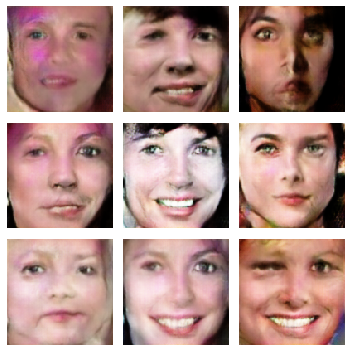

Epoch: 241, [Time: 7033.33 seg], g_loss: 3.8, d_loss: 0.2
Epoch: 242, [Time: 7060.59 seg], g_loss: 3.7, d_loss: 0.3
Epoch: 243, [Time: 7088.62 seg], g_loss: 4.7, d_loss: 0.3
Epoch: 244, [Time: 7116.70 seg], g_loss: 3.1, d_loss: 0.2
Epoch: 245, [Time: 7144.67 seg], g_loss: 3.4, d_loss: 0.5
Epoch: 246, [Time: 7172.00 seg], g_loss: 3.3, d_loss: 0.3
Epoch: 247, [Time: 7199.58 seg], g_loss: 3.5, d_loss: 0.3
Epoch: 248, [Time: 7227.57 seg], g_loss: 3.7, d_loss: 0.3
Epoch: 249, [Time: 7255.99 seg], g_loss: 4.0, d_loss: 0.2
Epoch: 250, [Time: 7284.21 seg], g_loss: 3.1, d_loss: 0.2


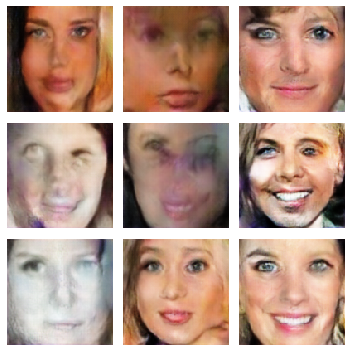

Epoch: 251, [Time: 7319.80 seg], g_loss: 4.7, d_loss: 0.3
Epoch: 252, [Time: 7348.47 seg], g_loss: 3.5, d_loss: 0.2
Epoch: 253, [Time: 7377.06 seg], g_loss: 3.5, d_loss: 0.3
Epoch: 254, [Time: 7405.22 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 255, [Time: 7432.93 seg], g_loss: 3.1, d_loss: 0.3
Epoch: 256, [Time: 7460.57 seg], g_loss: 3.8, d_loss: 0.3
Epoch: 257, [Time: 7489.05 seg], g_loss: 3.5, d_loss: 0.4
Epoch: 258, [Time: 7517.73 seg], g_loss: 3.3, d_loss: 0.6
Epoch: 259, [Time: 7546.53 seg], g_loss: 3.4, d_loss: 0.6
Epoch: 260, [Time: 7574.78 seg], g_loss: 4.0, d_loss: 0.2


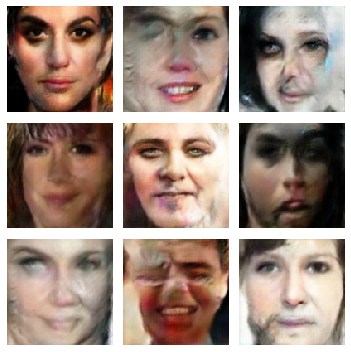

In [ ]:
# Training
start_time = time.time()
for e in range(1, EPOCHS+1):

    img_index = np.arange(x_train.shape[0])
    np.random.shuffle(img_index)

    batchs = range(x_train.shape[0] // BATCH_SIZE)
    for b in batchs:

        # TRAINING DISCRIMINATOR
        real_batch = x_train[img_index[b * BATCH_SIZE: (b+1) * BATCH_SIZE]]     # real images from the dataset
        noise = rand_vector(DISTRIBUTION_train, (BATCH_SIZE, INPUT_SHAPE))
        fake_batch = generator.predict(noise)                                   # fake images from the generator
        # Add random noise to the labels - important trick!
        real_labels = np.ones (BATCH_SIZE) - 0.05 * np.random.uniform(size=BATCH_SIZE)
        fake_labels = np.zeros(BATCH_SIZE) + 0.05 * np.random.uniform(size=BATCH_SIZE)
        index = np.arange(BATCH_SIZE*2); np.random.shuffle(index)

        batch = np.concatenate((real_batch, fake_batch), axis=0)[index][:BATCH_SIZE]
        label = np.concatenate((real_labels, fake_labels), axis=0)[index][:BATCH_SIZE]

        discriminador.trainable = True
        d_error = discriminador.train_on_batch(batch, label)

        # TRAINING GENERATOR
        discriminador.trainable = False
        noise = rand_vector(DISTRIBUTION_train, (BATCH_SIZE, INPUT_SHAPE))
        gError = gan.train_on_batch(noise, np.ones(BATCH_SIZE))

        if e == 1 and b == 0:
            d_loss_history = [d_error]
            g_loss_history = [gError]

    d_loss_history.append(d_error)
    g_loss_history.append(gError)
    print("Epoch: %d, [Time: %.2f seg], g_loss: %.1f, d_loss: %.1f"%(e, time.time()- start_time, gError, d_error))

    # Plot generated images
    if e == 1 or e % 10 == 0:
        generator.save(output_dir + 'generator.h5')
        gan.save(output_dir + 'gan.h5')
        plot_generated_images(str(e), generator, DISTRIBUTION_train)

        # Plot Learning Curves
        x_ = np.linspace(0, EPOCHS, num=len(d_loss_history))
        fig = plt.figure(figsize=(6, 5))
        plt.plot(x_, d_loss_history, color='blue', label='Discriminator')
        plt.plot(x_, g_loss_history, color='red', label='Generator')
        plt.legend()
        plt.xlim([0, EPOCHS])
        plt.grid(True)
        plt.title('Learning curves')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.tight_layout()
        plt.savefig(output_dir + "Learning_curves.png", dpi=500)
        plt.close()


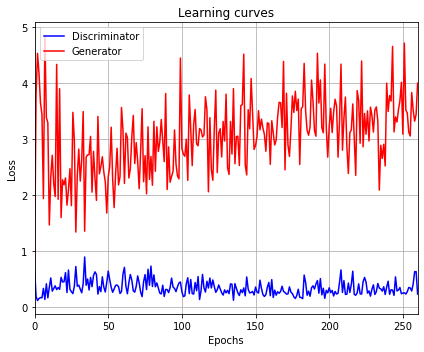

In [ ]:
# Plot Learning Curves
x_ = np.linspace(0, EPOCHS, num=len(d_loss_history))
fig = plt.figure(figsize=(6, 5))
plt.plot(x_, d_loss_history, color='blue', label='Discriminator')
plt.plot(x_, g_loss_history, color='red', label='Generator')
plt.legend()
plt.xlim([0, EPOCHS])
plt.grid(True)
plt.title('Learning curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig(output_dir + "Learning_curves.png", dpi=500)
plt.show()
#plt.close()

###**Test**

Mounted at /content/drive
Tr_ normal --- Ts_ normal


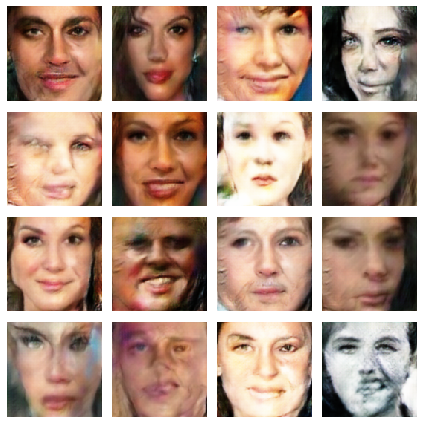

Tr_ normal --- Ts_ weibull


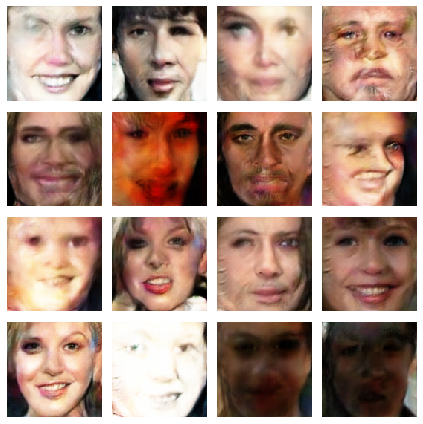

In [ ]:
# mount your Google Drive
import os
from google.colab import drive
from keras.models import load_model

drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/Face_generation/'

generator = load_model(output_dir + '/generator.h5')

print('Tr_ %s --- Ts_ %s'%(DISTRIBUTION_train, DISTRIBUTION_train))
plot_generated_images('Tr_ %s --- Ts_ %s'%(DISTRIBUTION_train, DISTRIBUTION_train), generator, DISTRIBUTION_train, samples=16, dim=(4,4), figsize=(6,6))

print('Tr_ %s --- Ts_ %s'%(DISTRIBUTION_train, DISTRIBUTION_test))
plot_generated_images('Tr_ %s --- Ts_ %s'%(DISTRIBUTION_train, DISTRIBUTION_test), generator, DISTRIBUTION_test, samples=16, dim=(4,4), figsize=(6,6))